In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib widget
import obspy
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta, aic_simple
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import coincidence_trigger
from obspy.signal.cross_correlation import correlation_detector
from obspy.signal import PPSD
from obspy import read_inventory
from obspy.realtime.signal import kurtosis

import spectrum


from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import obspy.signal.trigger as trigger
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plot_working
import event_processing
import loading_stream_function

import matplotlib.ticker as ticker
from datetime import datetime
from datetime import timedelta

In [3]:
chan = 'GHZ'
#statlist = [ 'A01' ,'A03' , 'A05' , 'A07' , 'A09' , 'A11' , 'A13' , 'A15' , 'A17' , 'A19' ]
statlist = [ 'A01' ,'A02' , 'A03' , 'A04' , 'A05' , 'A06' , 'A07' , 'A08' , 'A09', 'A10' , 'A11', 'A13', 'A14', 'A19']#, 'A16', 'A17', 'A18', 'A19' ]
#statlist = [ 'B01' ,'B02' , 'B03' , 'B04' , 'B06' , 'B07' , 'B08' , 'B09','B10' , 'B11', 'B12', 'B13' , 'B19' , 'B20']#,'B14','B15','B16','B17','B18','B19', 'B20' ]

day = 15
hr = 15
start_time = obspy.UTCDateTime('2020-1-' + str(day) + 'T00:00:00')+hr*3600
end_time = obspy.UTCDateTime('2020-1-' + str(day) + 'T00:00:00')+(hr+1)*3600
stream = obspy.read("/media/sbrent/Oman3/PASSCAL/Main_deployment/DAYS/" +statlist[0]+ "/*.." + chan +".2020.0" +str(day))


In [4]:
for s in statlist[1:]:
    
    stream += obspy.read("/media/sbrent/Oman3/PASSCAL/Main_deployment/DAYS/" + s + "/*.." + chan + ".2020.0" + str(day))


In [5]:
data = stream.slice(starttime=start_time,endtime=end_time) #look into trim()
#print(data)
print(start_time, end_time)

2020-01-15T15:00:00.000000Z 2020-01-15T16:00:00.000000Z


In [6]:
#data = data.decimate(2)
data1 = data.copy()
#stream_filt = data1.filter('highpass', corners=4, freq=80, zerophase=False)

In [7]:
stream_filt = data.filter('highpass', corners=4, freq=80, zerophase=False)
stream_2 = stream_filt.copy()

events = coincidence_trigger("classicstalta", 5, 0.8, stream_2, 3, sta=0.02, lta=0.2)




#events = coincidence_trigger("classicstalta", 4, 0.5, stream_2, 3, sta=0.08, lta=0.5)
events = pd.DataFrame(events)

In [8]:
event_id = 510
event_meta = events.iloc[event_id]
time = events.time[510]-1

In [9]:
g_wind1 = event_processing.get_event_window_raw(data1,time)

In [43]:
def zero_pad(data, N, k):
    data_length = N*k
    extra_zeros = np.zeros(int(data_length - data.shape[0]))
    data = np.append(data, extra_zeros)
    return data



def get_power_freq(N, NW, k, data):
    data = zero_pad(data, N, k)
    data = np.reshape(data, (k, N))
    w, eigens = spectrum.dpss(N, NW, k)
    sk, weights, eigenvalues = spectrum.pmtm(data, e=eigens, v=w, method='eigen')
    power = 10*np.log10(np.abs(np.mean(sk * sk.conj(), axis=0)))
    Tlength = 1000/(data.shape[0])
    print(Tlength)
    freq = np.ones(power.shape) * Tlength
    freq = freq.cumsum()
    return freq, power

In [33]:
data=g_wind1[0].data.copy()

250.0


(0.0, 500.0)

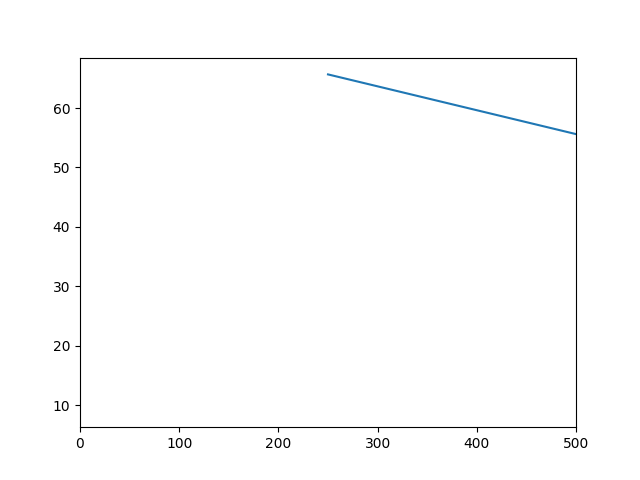

In [44]:
freq, power = get_power_freq(N=len(g_wind1[0].data), NW=3/2, k=4, data=g_wind1[0].data.copy())

fig, ax = plt.subplots()
ax.plot(freq, power)
ax.set_xlim(0, 500)

In [20]:
g_wind1[0].stats.delta

0.001